In [11]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
import tensorflow as tf

In [ ]:
dam="/kaggle/input/almond-prunus-dulcis-damage-detection/dataset/DAMAGED"


In [ ]:
train_data=image_dataset_from_directory(
    dam,
    image_size=(256,256),
    batch_size=32,
    label_mode=None
)
# train_data=train_data.map(lambda x:(x/255))

In [ ]:
for image in train_data.take(1):
    print(image.shape)

In [ ]:
datagen=ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    fill_mode="nearest",
    zoom_range=0.2, 
    horizontal_flip=True,
)

In [ ]:
new_data = train_data.map(lambda x:( tf.numpy_function(datagen.random_transform, [x], Tout=tf.float32),x))



# # GAN

In [12]:
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Input,Conv2DTranspose,Dropout,BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras.initializers import HeNormal
from keras.callbacks import EarlyStopping

In [13]:
def build_gan():
    
    inputs=Input(shape=(128,128,3))
    D=Conv2DTranspose(128,(3,3),strides=(1,1),activation="relu",padding="same",kernel_regularizer=l2(0.01),kernel_initializer=HeNormal())(inputs)
    D=Dropout(0.5)(D)
    D=BatchNormalization()(D)
    D=Conv2DTranspose(64,(3,3),strides=(1,1),activation="relu",padding="same",kernel_regularizer=l2(0.01),kernel_initializer=HeNormal())(D)
    D=Dropout(0.5)(D)
    D=BatchNormalization()(D)
    D=Conv2DTranspose(32,(3,3),strides=(1,1),activation="relu",padding="same",kernel_regularizer=l2(0.01),kernel_initializer=HeNormal())(D)
    D=BatchNormalization()(D)
    outputs=Conv2D(3,(3,3),activation="tanh",padding="same")(D)
    gen=Model(inputs,outputs)
    return gen
    
def build_discrim():
    inputs=Input(shape=(128,128,3))
    D=Conv2D(32,(3,3),activation="relu",padding="same",kernel_regularizer=l2(0.01),kernel_initializer=HeNormal())(inputs)
    D=Dropout(0.5)(D)
    D=BatchNormalization()(D)
    D=MaxPooling2D(2,2)(D)
    D=Conv2D(64,(3,3),activation="relu",padding="same",kernel_regularizer=l2(0.01),kernel_initializer=HeNormal())(D)
    D=Dropout(0.5)(D)
    D=BatchNormalization()(D)
    D=MaxPooling2D(2,2)(D)

    D=Conv2D(128,(3,3),activation="relu",padding="same",kernel_regularizer=l2(0.01),kernel_initializer=HeNormal())(D)
#     D=Dropout(0.5)(D)
    D=MaxPooling2D(2,2)(D)

    D=BatchNormalization()(D)
#     outputs=Conv2D(3,activation="softmax")(D)
    D=Flatten()(D)
    outputs=Dense(1,activation="sigmoid")(D)
    discrim=Model(inputs,outputs)
    return discrim
    
def train_gen(generator,discriminator):
    discriminator.trainable=False
    discriminator.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    noise_input=Input(shape=(128,128,3))
    generat_data=generator(noise_input)
    discrim=discriminator(generat_data)
    gen=Model(noise_input,discrim)
    return gen
generator=build_gan()
discriminator=build_discrim()
discriminator.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model=train_gen(generator,discriminator)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_19 (Functional)      │ (None, 128, 128, 3)    │        97,603 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_21 (Functional)      │ (None, 1)              │       126,913 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,516 (877.02 KB)

 Trainable params: 97,155 (379.51 KB)

 Non-trainable params: 127,361 (497.50 KB)

In [14]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1./128) 

train_data_dir = '/kaggle/input/almond-prunus-dulcis-damage-detection/dataset'  
train_data = data_gen.flow_from_directory(train_data_dir, target_size=(128, 128), batch_size=32, class_mode=None)

def generate_real_samples(data_gen, batch_size):
    real_samples = next(data_gen)
    real_labels = np.ones((batch_size, 1))  
    return real_samples, real_labels

def generate_fake_samples(generator, batch_size):
    noise = np.random.randn(batch_size, 128, 128, 3) 
    fake_samples = generator.predict(noise)
    fake_labels = np.zeros((batch_size, 1)) 
    return fake_samples, fake_labels

def train_gan(generator, discriminator, gan, data_gen, epochs=1000, batch_size=32):
    discriminator.trainable = True
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    for epoch in range(epochs):
        real_samples, real_labels = generate_real_samples(data_gen, batch_size)
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_real_value = d_loss_real[0]  
        d_acc_real_value = d_loss_real[1]  
        
        fake_samples, fake_labels = generate_fake_samples(generator, batch_size)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        d_loss_fake_value = d_loss_fake[0] 
        d_acc_fake_value = d_loss_fake[1]  
        
        discriminator.trainable = False
        gan_labels = np.ones((batch_size, 1)) 
        noise = np.random.randn(batch_size, 128, 128, 3)
        g_loss = gan.train_on_batch(noise, gan_labels)
        
        
        
#         if epoch % 100 == 0:
#             print(f"Epoch {epoch}, D_loss_real={d_loss_real_value:.3f}, D_acc_real={d_acc_real_value:.3f}, "
#                   f"D_loss_fake={d_loss_fake_value:.3f}, D_acc_fake={d_acc_fake_value:.3f}, G_loss={g_loss:.3f}")
        
        discriminator.trainable = True



generator = build_gan()
discriminator = build_discrim()

gan = train_gen(generator, discriminator)
gan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

train_gan(generator, discriminator, gan, train_data, epochs=10, batch_size=32)


Found 736 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


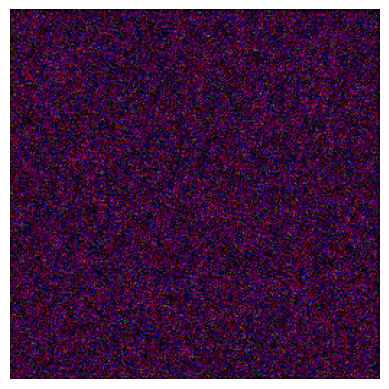

In [21]:
import numpy as np
import matplotlib.pyplot as plt


def generate_samples(generator, num_samples=1):
    latent_dim = (num_samples, 256, 256, 3)  
    noise = np.random.randn(*latent_dim)

    generated_samples = generator.predict(noise)

    return generated_samples

generated_data = generate_samples(generator, num_samples=5)

plt.imshow((generated_data[0]))  
plt.axis('off')
plt.show()


# # Deep Learning

In [26]:
inputs=Input(shape=(128,128,3))
C=Conv2D(32,(3,3),activation='relu',padding='same')(inputs)
C=Conv2DTranspose(32,(3,3),activation="relu",strides=(2,2),padding='same')(C)
C=Conv2D(3,(3,3),activation="softmax")(C)
model=Model(inputs,C)
model.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [28]:
model.fit(train_data,train_data)

ValueError: When providing `x` as a PyDataset, `y` should not be passed. Instead, the targets should be included as part of the PyDataset.